# Analysis of Object Detection Performance Based on Faster RCNN

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import os
from PIL import Image
import xml.etree.ElementTree as ET

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision import transforms
import torchvision.ops as ops

### Setting up the GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


### Model Parameters

In [3]:
# image width after resizing
M = 224
# image height after resizing
N = 224


## Loading the Dataset

### Creating the Dataset Class

In [4]:
class ImagesDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_list = sorted(file for file in os.listdir(root_dir) if file.endswith('.jpg'))

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = self.images_list[idx]
        img_path = os.path.join(self.root_dir, img_name)
        xml_path = os.path.join(self.root_dir, img_name.replace('.jpg', '.xml'))

        image = Image.open(img_path).convert('RGB')

        annotation = self.parse_xml(xml_path)

        if self.transform:
            image = self.transform(image)
            # should change annotation as well in case of resizing
            annotation['bbox'][0] = annotation['bbox'][0] * M / annotation['width']
            annotation['bbox'][1] = annotation['bbox'][1] * N / annotation['height']
            annotation['bbox'][2] = annotation['bbox'][2] * M / annotation['width']
            annotation['bbox'][3] = annotation['bbox'][3] * N / annotation['height']
            annotation['width'] = M
            annotation['height'] = N

        return image, annotation
    
    def parse_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotation = {
            "filename": root.find("filename").text,
            "width": int(root.find("size/width").text),
            "height": int(root.find("size/height").text),
            "depth": int(root.find("size/depth").text),
            "name": root.find("object/name").text,
            "bbox": [
                int(root.find("object/bndbox/xmin").text),
                int(root.find("object/bndbox/ymin").text),
                int(root.find("object/bndbox/xmax").text),
                int(root.find("object/bndbox/ymax").text),
            ],
        }

        return annotation


### Defining the Transforms

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize((M, N)),
    transforms.ToTensor(),
])

transforms_val = transforms.Compose([
    transforms.Resize((M, N)),
    transforms.ToTensor(),
])

transforms_test = transforms.Compose([
    transforms.Resize((M, N)),
    transforms.ToTensor(),
])

### Creating the Dataset Objects

In [6]:
# modify the root_dir to the path of the dataset
train_dataset = ImagesDataset(root_dir='/kaggle/input/wildfiresmoke-v1/Wildfire Smoke.v1-raw.voc/train', transform=transforms_train)
val_dataset = ImagesDataset(root_dir='/kaggle/input/wildfiresmoke-v1/Wildfire Smoke.v1-raw.voc/valid', transform=transforms_val)
test_dataset = ImagesDataset(root_dir='/kaggle/input/wildfiresmoke-v1/Wildfire Smoke.v1-raw.voc/test', transform=transforms_test)

### Showing Sample Images

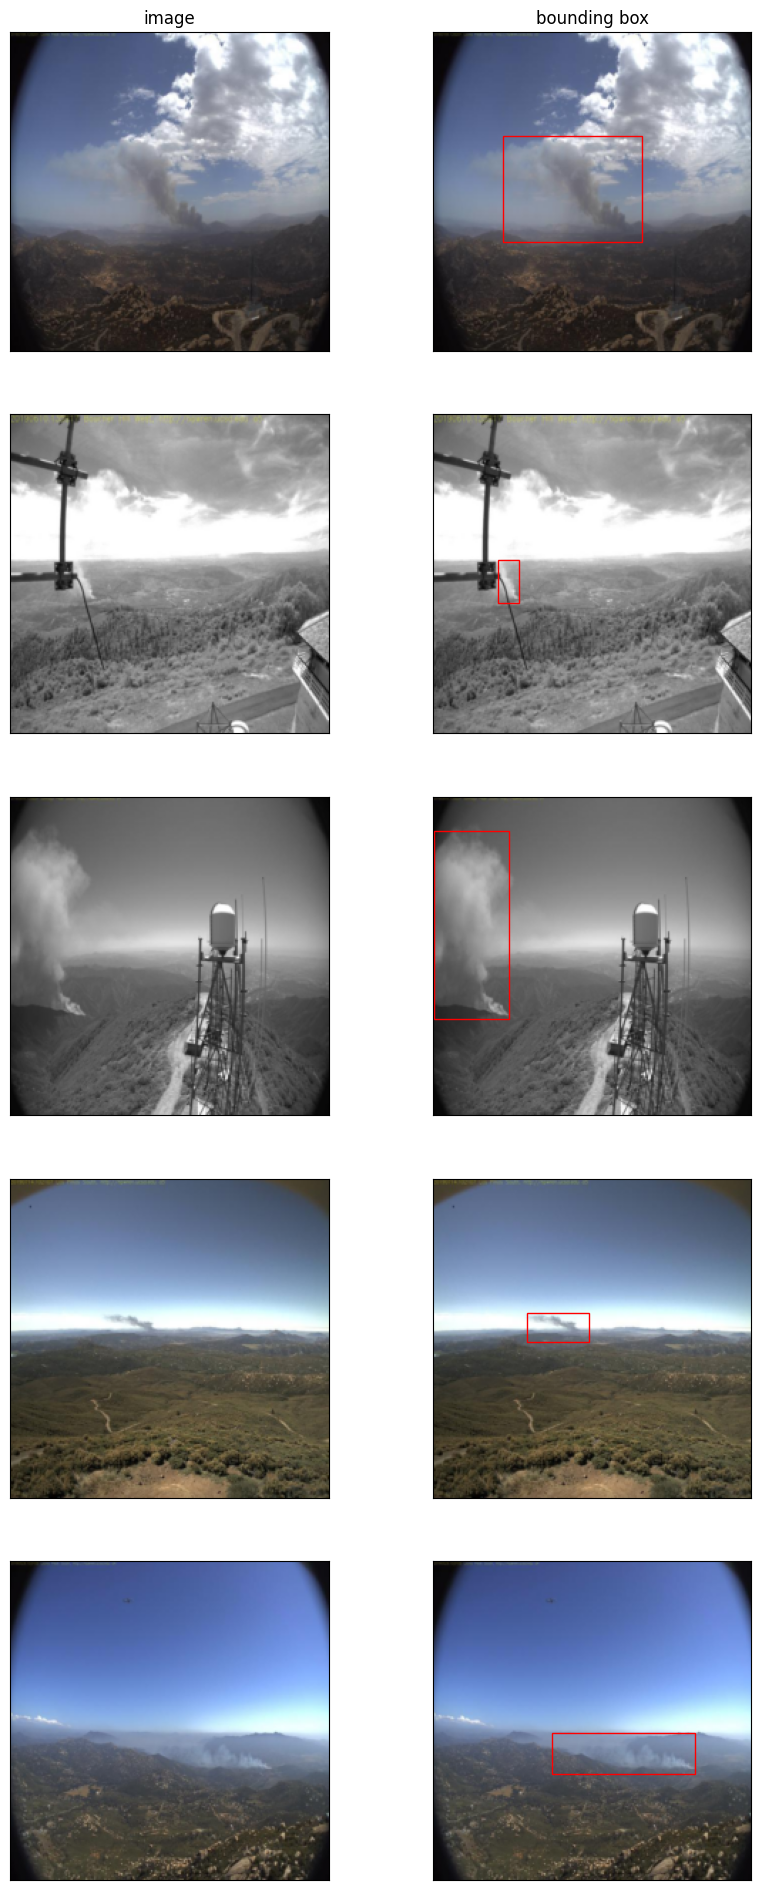

In [7]:
samples_count = 5
fig, axes = plt.subplots(samples_count, 2, figsize=(10, 24))
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for i in range(samples_count):
    idx = np.random.randint(len(train_dataset))
    image, annotation = train_dataset[idx]
    axes[i, 0].imshow(image.permute(1, 2, 0))
    axes[i, 1].imshow(image.permute(1, 2, 0))
    axes[i, 1].add_patch(plt.Rectangle((annotation['bbox'][0], annotation['bbox'][1]),
                                       annotation['bbox'][2] - annotation['bbox'][0],
                                       annotation['bbox'][3] - annotation['bbox'][1],
                                       fill=False, color='r'))
    if i == 0:
        axes[i, 0].set_title('image')
        axes[i, 1].set_title('bounding box')
    

## Implementing the Faster R-CNN Model

In [8]:
class_names = ['smoke', 'no_smoke']
class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(class_to_idx)
print(idx_to_class)

{'smoke': 0, 'no_smoke': 1}
{0: 'smoke', 1: 'no_smoke'}


In [9]:
class FasterRCNN(nn.Module):

    def __init__(self, num_classes):
        super(FasterRCNN, self).__init__()

        self.num_classes = num_classes
        self.threshold = 0.7

        # --- Feature Extractor ---
        # we are using VGG16 as the feature extractor
        # the pretrained weights are downloaded from torchvision
        # the pretrained weights are frozen
        self.feature_extractor = torchvision.models.vgg16(pretrained=True)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # ---   THE CONV LAYERS  ---
        # The Conv layers contains 13 conv layers, 13 ReLU layers and 4 pooling layers
        # All the conv layers are: kernel_size=3, pad=1, stride=1
        # All the pooling layers are: kernel_size=2, stride=2
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # ---   REGION PROPOSAL NETWORK (RPN)  ---
        # The RPN is used to generate region proposals
        # The RPN takes the feature maps generated by the conv layers as input
        # The RPN has 1 conv layer with 512 channels, kernel_size=3, padding=1 
        # The RPN has 2 output layers:
        #   - 1 output layer with 2k scores for the k anchors (object / not object)
        #   - 1 output layer with 4k bounding box coordinates for the k anchors
        self.rpn_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.rpn_objectness = nn.Conv2d(512, 2 * 9, kernel_size=1)
        # reshape from  B x H x W x 18 to B x 2 x 9 x H x W
        self.rpn_objectness_softmax = nn.Softmax(dim=1)
        # reshape from  B x 2 x 9 x H x W to B x 18 x H x W

        self.rpn_bbox = nn.Conv2d(512, 4 * 9, kernel_size=1)

        # ---   REGION OF INTEREST (ROI) POOLING  ---
        # The ROI Pooling layer is used to perform max pooling on inputs of non-uniform sizes to obtain fixed-size feature maps (7x7)
        # The ROI Pooling layer takes as input:
        #   - the proposed regions generated by the RPN
        # The ROI Pooling layer outputs k feature maps of size 7x7
        self.roi_pool = nn.AdaptiveMaxPool2d((7, 7))

        # ---   FULLY CONNECTED LAYERS  ---
        # The FC layers are used for classification and regression
        # The FC layers take as input the k feature maps generated by the ROI Pooling layer
        # The FC layers have 2 output layers:
        #   - 1 output layer with 4096 units for classification
        #   - 1 output layer with 4096 units for regression

        self.classification_FC = nn.Sequential(
            # nn.Dropout(),

            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),

            # nn.Dropout(),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )

        self.classification_classifier = nn.Sequential(
            nn.Linear(4096, self.num_classes),
            nn.Softmax(dim=1),
        )

        self.classification_bbox_regressor = nn.Sequential(
            nn.Linear(4096, self.num_classes * 4),
        )

    def forward(self, x):
        print(f'input shape: {x.shape}')
        x = self.features(x)
        print(f'features output shape: {x.shape}')
        x = self.rpn_conv(x)
        print(f'rpn_conv output shape: {x.shape}')

        objectness = self.rpn_objectness(x)
        # reshape from  B x H x W x 18 to B x 2 x 9 x H x W
        objectness = objectness.reshape(objectness.shape[0], 2, 9, objectness.shape[2], objectness.shape[3])
        objectness = self.rpn_objectness_softmax(objectness)
        # reshape from  B x 2 x 9 x H x W to B x 18 x H x W
        objectness = objectness.reshape(objectness.shape[0], 18, objectness.shape[3], objectness.shape[4])

        bbox = self.rpn_bbox(x)

        print(f'objectness shape: {objectness.shape}')
        print(f'bbox shape: {bbox.shape}')

        # proposal layer
        # 1. Generate proposals based on RPN predicted offset and positive bounding box
        # reshape bbox from B x 36 x H x W to B x H x W x 9 x 4
        bbox = bbox.reshape(bbox.shape[0], bbox.shape[2], bbox.shape[3], 9, 4)
        proposal_layer = ops.box_convert(bbox, in_fmt='xyxy', out_fmt='xywh')
        proposal_layer = ops.box_iou(proposal_layer, proposal_layer)
        # 2. Process the bbox that exceeds the image boundary, and treat the image boundary as the boundary of the bbox that exceeds the boundary;
        proposal_layer = ops.clip_boxes_to_image(proposal_layer, (M, N))
        # 3. Remove bboxes less than the threshold;
        proposal_layer = proposal_layer[objectness > self.threshold]
        # 4. Sort the remaining bboxes according to the score from large to small;
        proposal_layer = proposal_layer[objectness.argsort(descending=True)]
        # 5. Take the top 6000 bboxes with the highest score;
        proposal_layer = proposal_layer[:6000]
        # 6. Perform NMS on the remaining bboxes, and the IoU threshold is 0.7;
        proposal_layer = ops.nms(proposal_layer, proposal_layer, iou_threshold=0.7)
        # 7. Take the top 300 bboxes with the highest score.
        # CHECKME: shouldn't sort them here?
        proposal_layer = proposal_layer[:300]

        # CHECKME: x?
        x = self.roi_pool(x, proposal_layer)

        x = torch.flatten(x, start_dim=1)

        x = self.classification_FC(x)

        classification = self.classification_classifier(x)

        bbox_regression = self.classification_bbox_regressor(x)

        return objectness, bbox, classification, bbox_regression



## Training the Model

In [10]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):

    train_loss_vals = []
    val_loss_vals = []

    for epoch in tqdm.tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        epoch_train_loss = []
        epoch_val_loss = []

        model.train()
        for images, annotations in train_dataloader:
            images = images.to(device)
            # annotations = annotations.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, annotations)

            loss.backward()
            epoch_train_loss.append(loss.item())

            optimizer.step()

        model.eval()
        with torch.no_grad():
            for images, annotations in val_dataloader:
                images = images.to(device)
                # annotations = annotations.to(device)

                outputs = model(images)

                loss = criterion(outputs, annotations)

                epoch_val_loss.append(loss.item())

        train_loss_vals.append(np.mean(epoch_train_loss))
        val_loss_vals.append(np.mean(epoch_val_loss))

        print('train loss: {:.4f} val loss: {:.4f}'.format(np.mean(epoch_train_loss), np.mean(epoch_val_loss)))
        print('-' * 10)
        print()

    return train_loss_vals, val_loss_vals


In [11]:
def plot_training_summary(train_loss_vals, val_loss_vals):
    plt.plot(train_loss_vals, label='train loss')
    plt.plot(val_loss_vals, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Data Loader

In [12]:
train_batch_size = 2
val_batch_size = 1
test_batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [13]:
model = FasterRCNN(num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [14]:
num_epochs = 10
train_loss_vals, val_loss_vals = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)


In [15]:
plot_training_summary(train_loss_vals, val_loss_vals)

### Built-in model

In [16]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 165MB/s]  


In [17]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)


In [18]:
# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# hidden_layer = 256 
# model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

In [ ]:
num_epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

for epoch in tqdm.tqdm(range(num_epochs)):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    epoch_train_loss = []
    epoch_val_loss = []

    model.train()
    for images, annotations in train_dataloader:
        images = list(image.to(device) for image in images)
        annotations_list = []
        for i in range(len(images)):
            single_annotation = {}
            for key, value in annotations.items():
                if isinstance(value[i], torch.Tensor):
                    single_annotation[key] = value[i].to(device)
                else:
                    single_annotation[key] = value[i]
            annotations_list.append(single_annotation)

        loss_dict = model(images, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_train_loss.append(losses.item())

    model.eval()
    with torch.no_grad():
        for images, annotations in val_dataloader:
            images = images.to(device)
            annotations_list = []
            for i in range(len(images)):
                single_annotation = {}
                for key, value in annotations.items():
                    if isinstance(value[i], torch.Tensor):
                        single_annotation[key] = value[i].to(device)
                    else:
                        single_annotation[key] = value[i]
                annotations_list.append(single_annotation)

            loss_dict = model(images, annotations)
            losses = sum(loss for loss in loss_dict.values())

            epoch_val_loss.append(losses.item())

    print('train loss: {:.4f} val loss: {:.4f}'.format(np.mean(epoch_train_loss), np.mean(epoch_val_loss)))
    print('-' * 10)
    print()

In [ ]:
for images, annotations in test_dataloader:
    images = images.to(device)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

    loss_dict = model(images, annotations)
    losses = sum(loss for loss in loss_dict.values())

    print(losses)

## Evaluating the Model